In [1]:
import scanpy as sc
import decoupler as dc
import numpy as np

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import anndata as ad
import os
import scanpy as sc
from tqdm import tqdm
import scanpy.external as sce
import celltypist

In [3]:
import celltypist
from celltypist import models
# models.download_models(force_update = False)
model = models.Model.load(model = 'Immune_All_Low.pkl');

In [4]:
import logging
celltypist.logger.set_level(logging.CRITICAL)

In [73]:
folder_path = '/Users/koush/Downloads/GSE215121_RAW/'
h5_files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

adatas = []
b = 0
raw = []
for file in tqdm(h5_files):
    adata = sc.read_10x_h5(os.path.join(folder_path, file))
    adata.var_names_make_unique()
    adata.layers['raw_count'] = adata.X.copy()
    sc.pp.filter_cells(adata, min_genes=10)
    sc.pp.filter_genes(adata, min_cells=1)
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    # adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[:, ~adata.var_names.str.startswith('MT-')]
    adata = adata[adata.obs.pct_counts_mt < 5, :]
    raw.append(adata.layers['raw_count'])

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    adata.obs['batch'] = b

    predictions = celltypist.annotate(
        adata, 
        # model = 'Immune_All_Low.pkl',
        model = 'Immune_All_High.pkl',
        majority_voting = True,
    )

    adatas.append(predictions.to_adata())
    b += 1

100%|██████████| 11/11 [01:07<00:00,  6.18s/it]


In [108]:
adata = ad.concat(adatas)

In [109]:
from scipy.sparse import vstack

In [110]:
adata

AnnData object with n_obs × n_vars = 37978 × 17499
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    obsm: 'X_pca'
    layers: 'raw_count'

In [111]:
adata.layers['raw_count'].shape

(37978, 17499)

In [112]:
np.intersect1d(adata.var_names,['CD4', 'FOXP3', 'CD8A', 'IFNG'])

array(['CD4', 'CD8A', 'FOXP3', 'IFNG'], dtype=object)

In [113]:
# sc.pp.neighbors(adata)
# sc.pp.pca(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=8000, subset=True)

In [114]:
np.intersect1d(adata.var_names,['CD4', 'FOXP3', 'CD8A', 'IFNG'])

array(['CD4', 'CD8A', 'FOXP3', 'IFNG'], dtype=object)

In [115]:
# sc.pp.filter_cells(adata, min_genes=10)
# sc.pp.filter_genes(adata, min_cells=10)
# adata.var['mt'] = adata.var_names.str.startswith('MT-')
# sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :]

# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.layers['log_norm'] = adata.X.copy()
# sc.pp.pca(adata)
# sc.pp.highly_variable_genes(adata, n_top_genes=8000, subset=True)
# sc.pp.neighbors(adata)

In [116]:
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [117]:
adata.layers

Layers with keys: raw_count

In [118]:
adata.obs.batch.value_counts()

batch
10    9564
1     4209
8     4130
5     3949
4     3347
3     3144
7     2831
9     2602
0     1599
2     1475
6     1128
Name: count, dtype: int64

In [119]:
adata = adata[adata.obs.batch == 10]
adata

View of AnnData object with n_obs × n_vars = 9564 × 8000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'raw_count'

In [120]:
sc.pp.neighbors(adata)
sc.tl.pca(adata)
sc.tl.umap(adata)

In [121]:
[i for i in adata.var_names if 'HIF' in i]

['HIF1A', 'HIF1A-AS2']

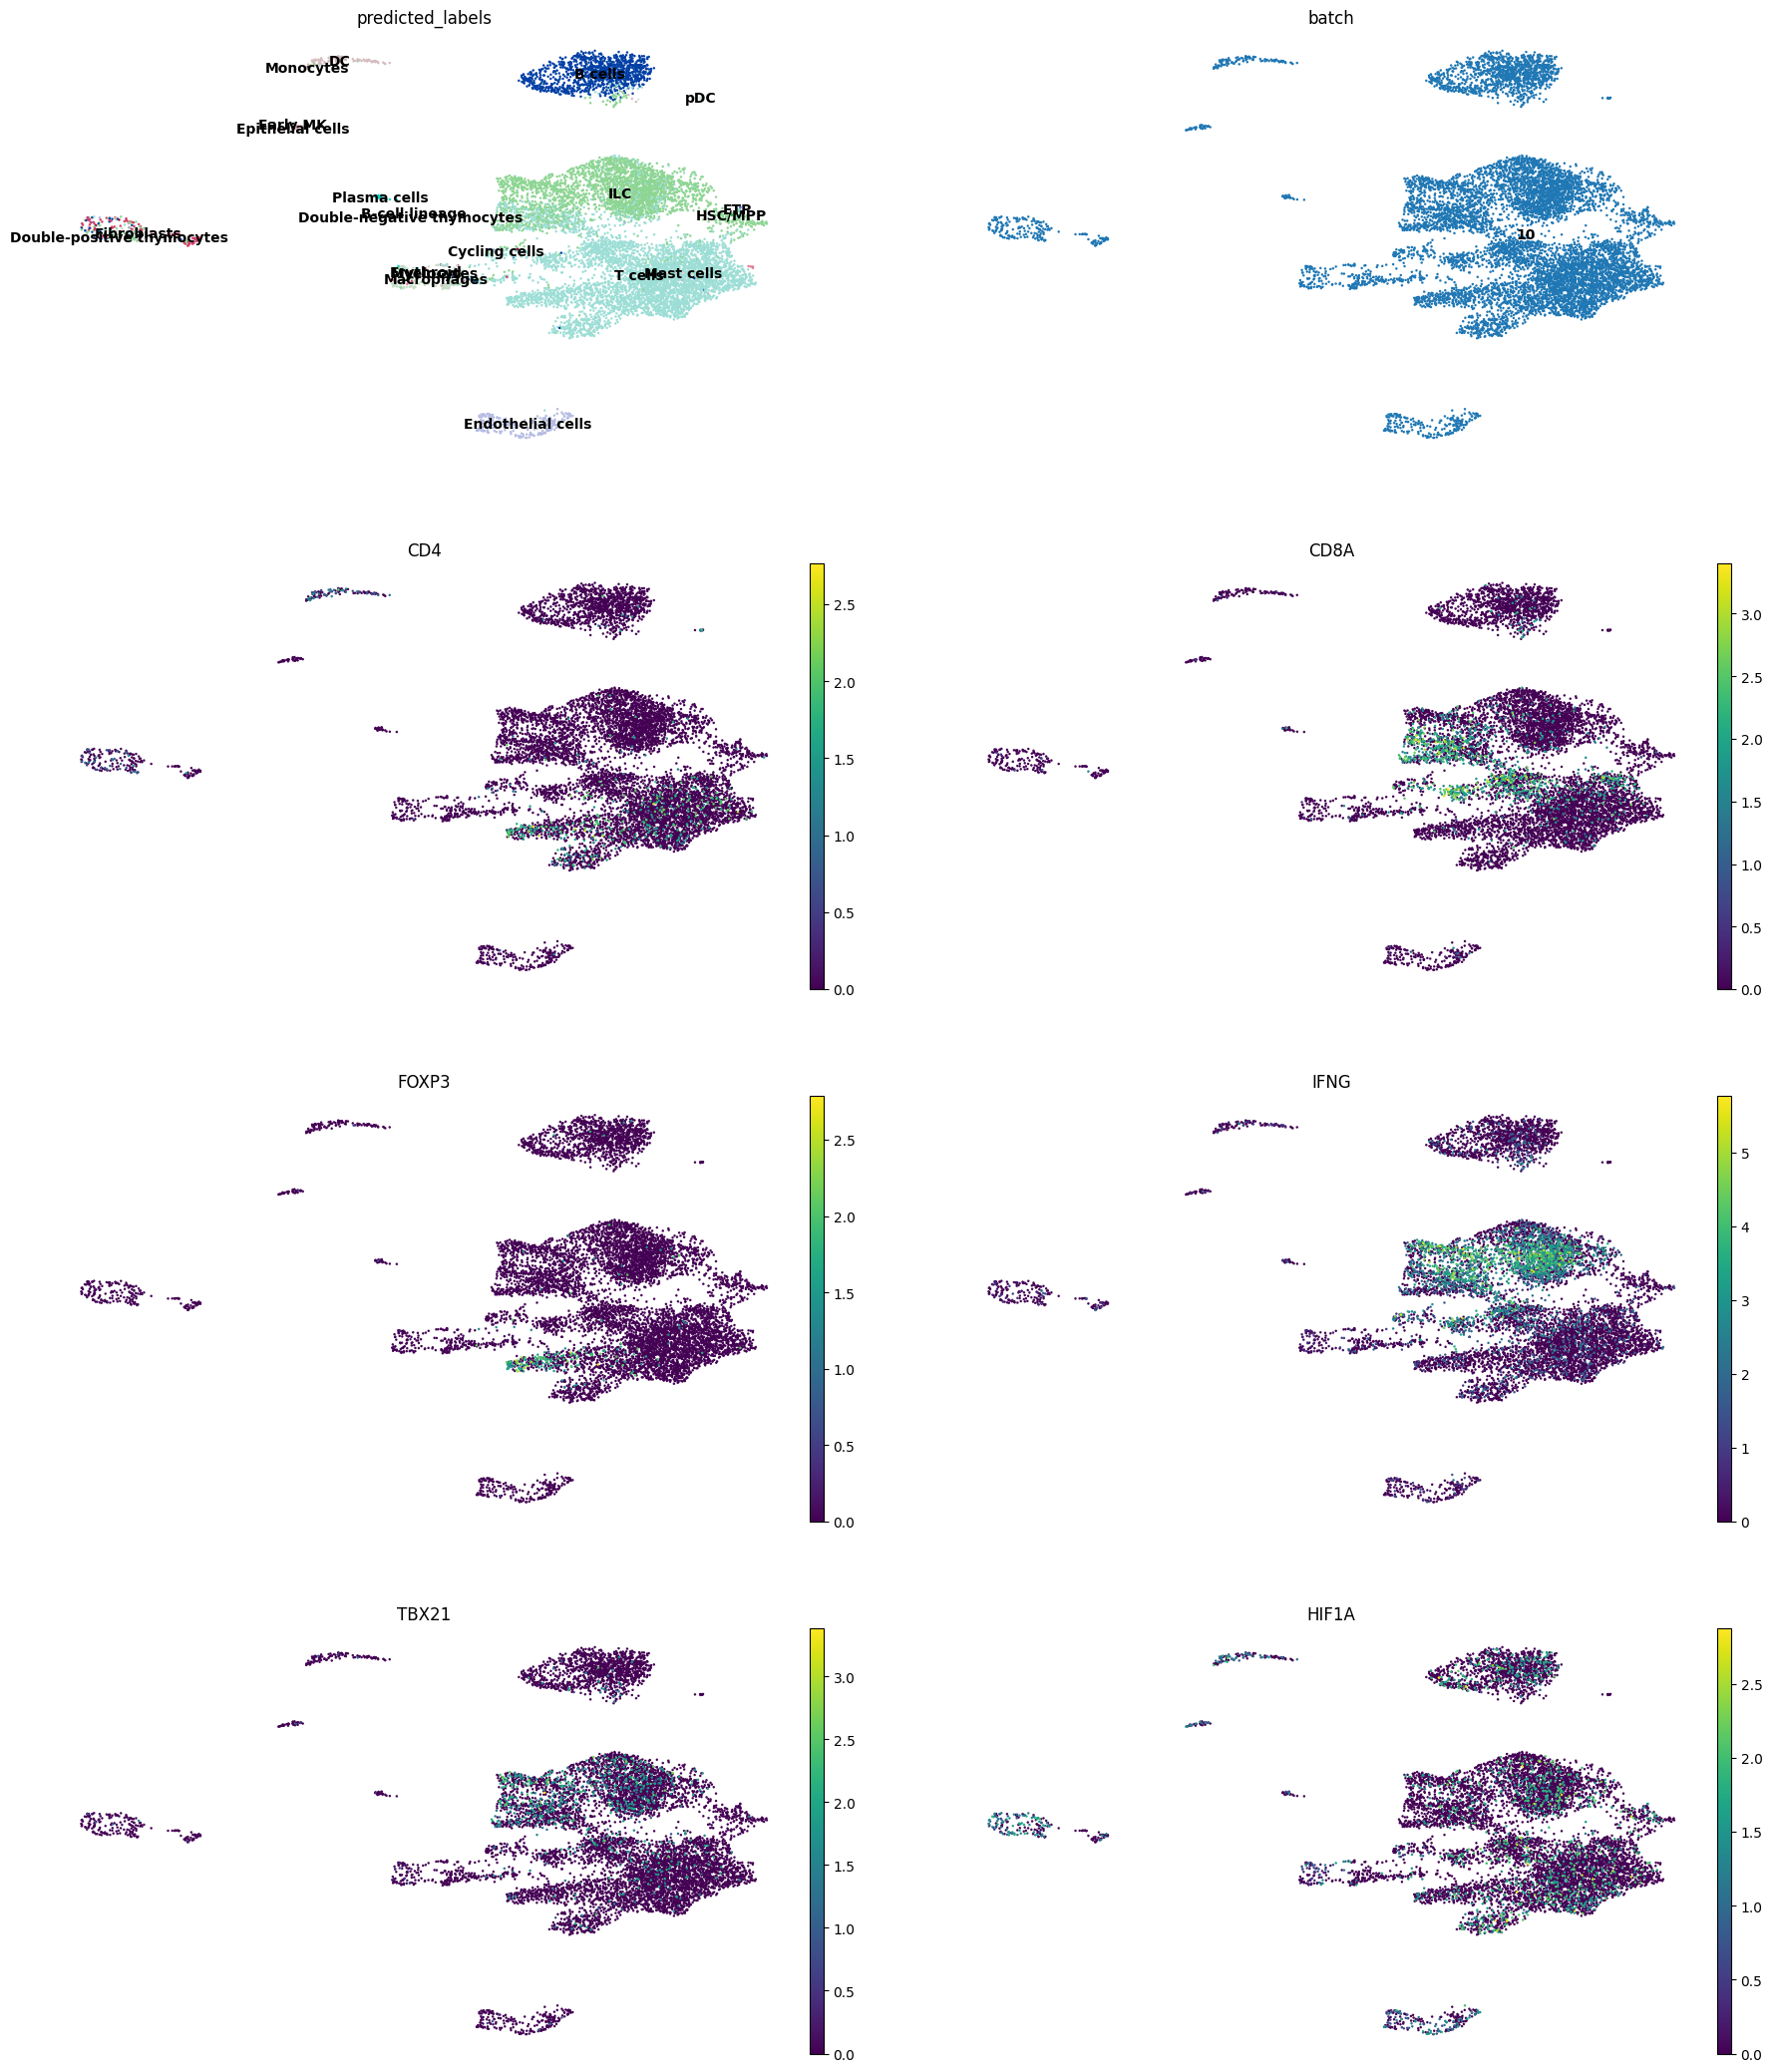

In [122]:
sc.pl.umap(
    adata, 
    color = ['predicted_labels', 'batch', 'CD4', 'CD8A', 'FOXP3', 'IFNG', 'TBX21', 'HIF1A'], 
    ncols=2, legend_loc='on data', frameon=False
)

In [123]:
adata.obs[['batch']].describe()

batch
count    9564
unique      1
top        10
freq     9564

In [256]:
import scanorama

In [257]:
alldata = {}
for batch in adata.obs['batch'].unique():
    alldata[batch] = adata[adata.obs['batch'] == batch,]

In [258]:
alldata2 = dict()
for ds in alldata.keys():
    alldata2[ds] = alldata[ds]

#convert to list of AnnData objects
adatas = list(alldata2.values())


In [259]:
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 8000 genes among all datasets
[[0.         0.00500313 0.06779661 0.03064415 0.0068793  0.7123202
  0.0212766  0.02251407 0.00187617 0.00250156 0.18073796]
 [0.         0.         0.04610169 0.09637405 0.03286525 0.02328344
  0.03457447 0.04026846 0.40841055 0.01114527 0.00118793]
 [0.         0.         0.         0.30947837 0.51728814 0.04542373
  0.07535461 0.07735782 0.07186441 0.06508475 0.02237288]
 [0.         0.         0.         0.         0.43734097 0.16062341
  0.32446809 0.21052632 0.07856234 0.0388163  0.24045802]
 [0.         0.         0.         0.         0.         0.08407192
  0.07978723 0.18509361 0.0566586  0.12375096 0.02718853]
 [0.         0.         0.         0.         0.         0.
  0.2570922  0.09572589 0.01283293 0.00691776 0.45454545]
 [0.         0.         0.         0.         0.         0.
  0.         0.4893617  0.0212766  0.01861702 0.05141844]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.13952667 0.12

In [260]:
adata_old = adata.copy()

In [272]:
adata = corrected[0].concatenate(corrected[1:])

In [274]:
adata.layers = adata_old.layers.copy()

In [275]:
adata.obs_names_make_unique(join='_')

In [276]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

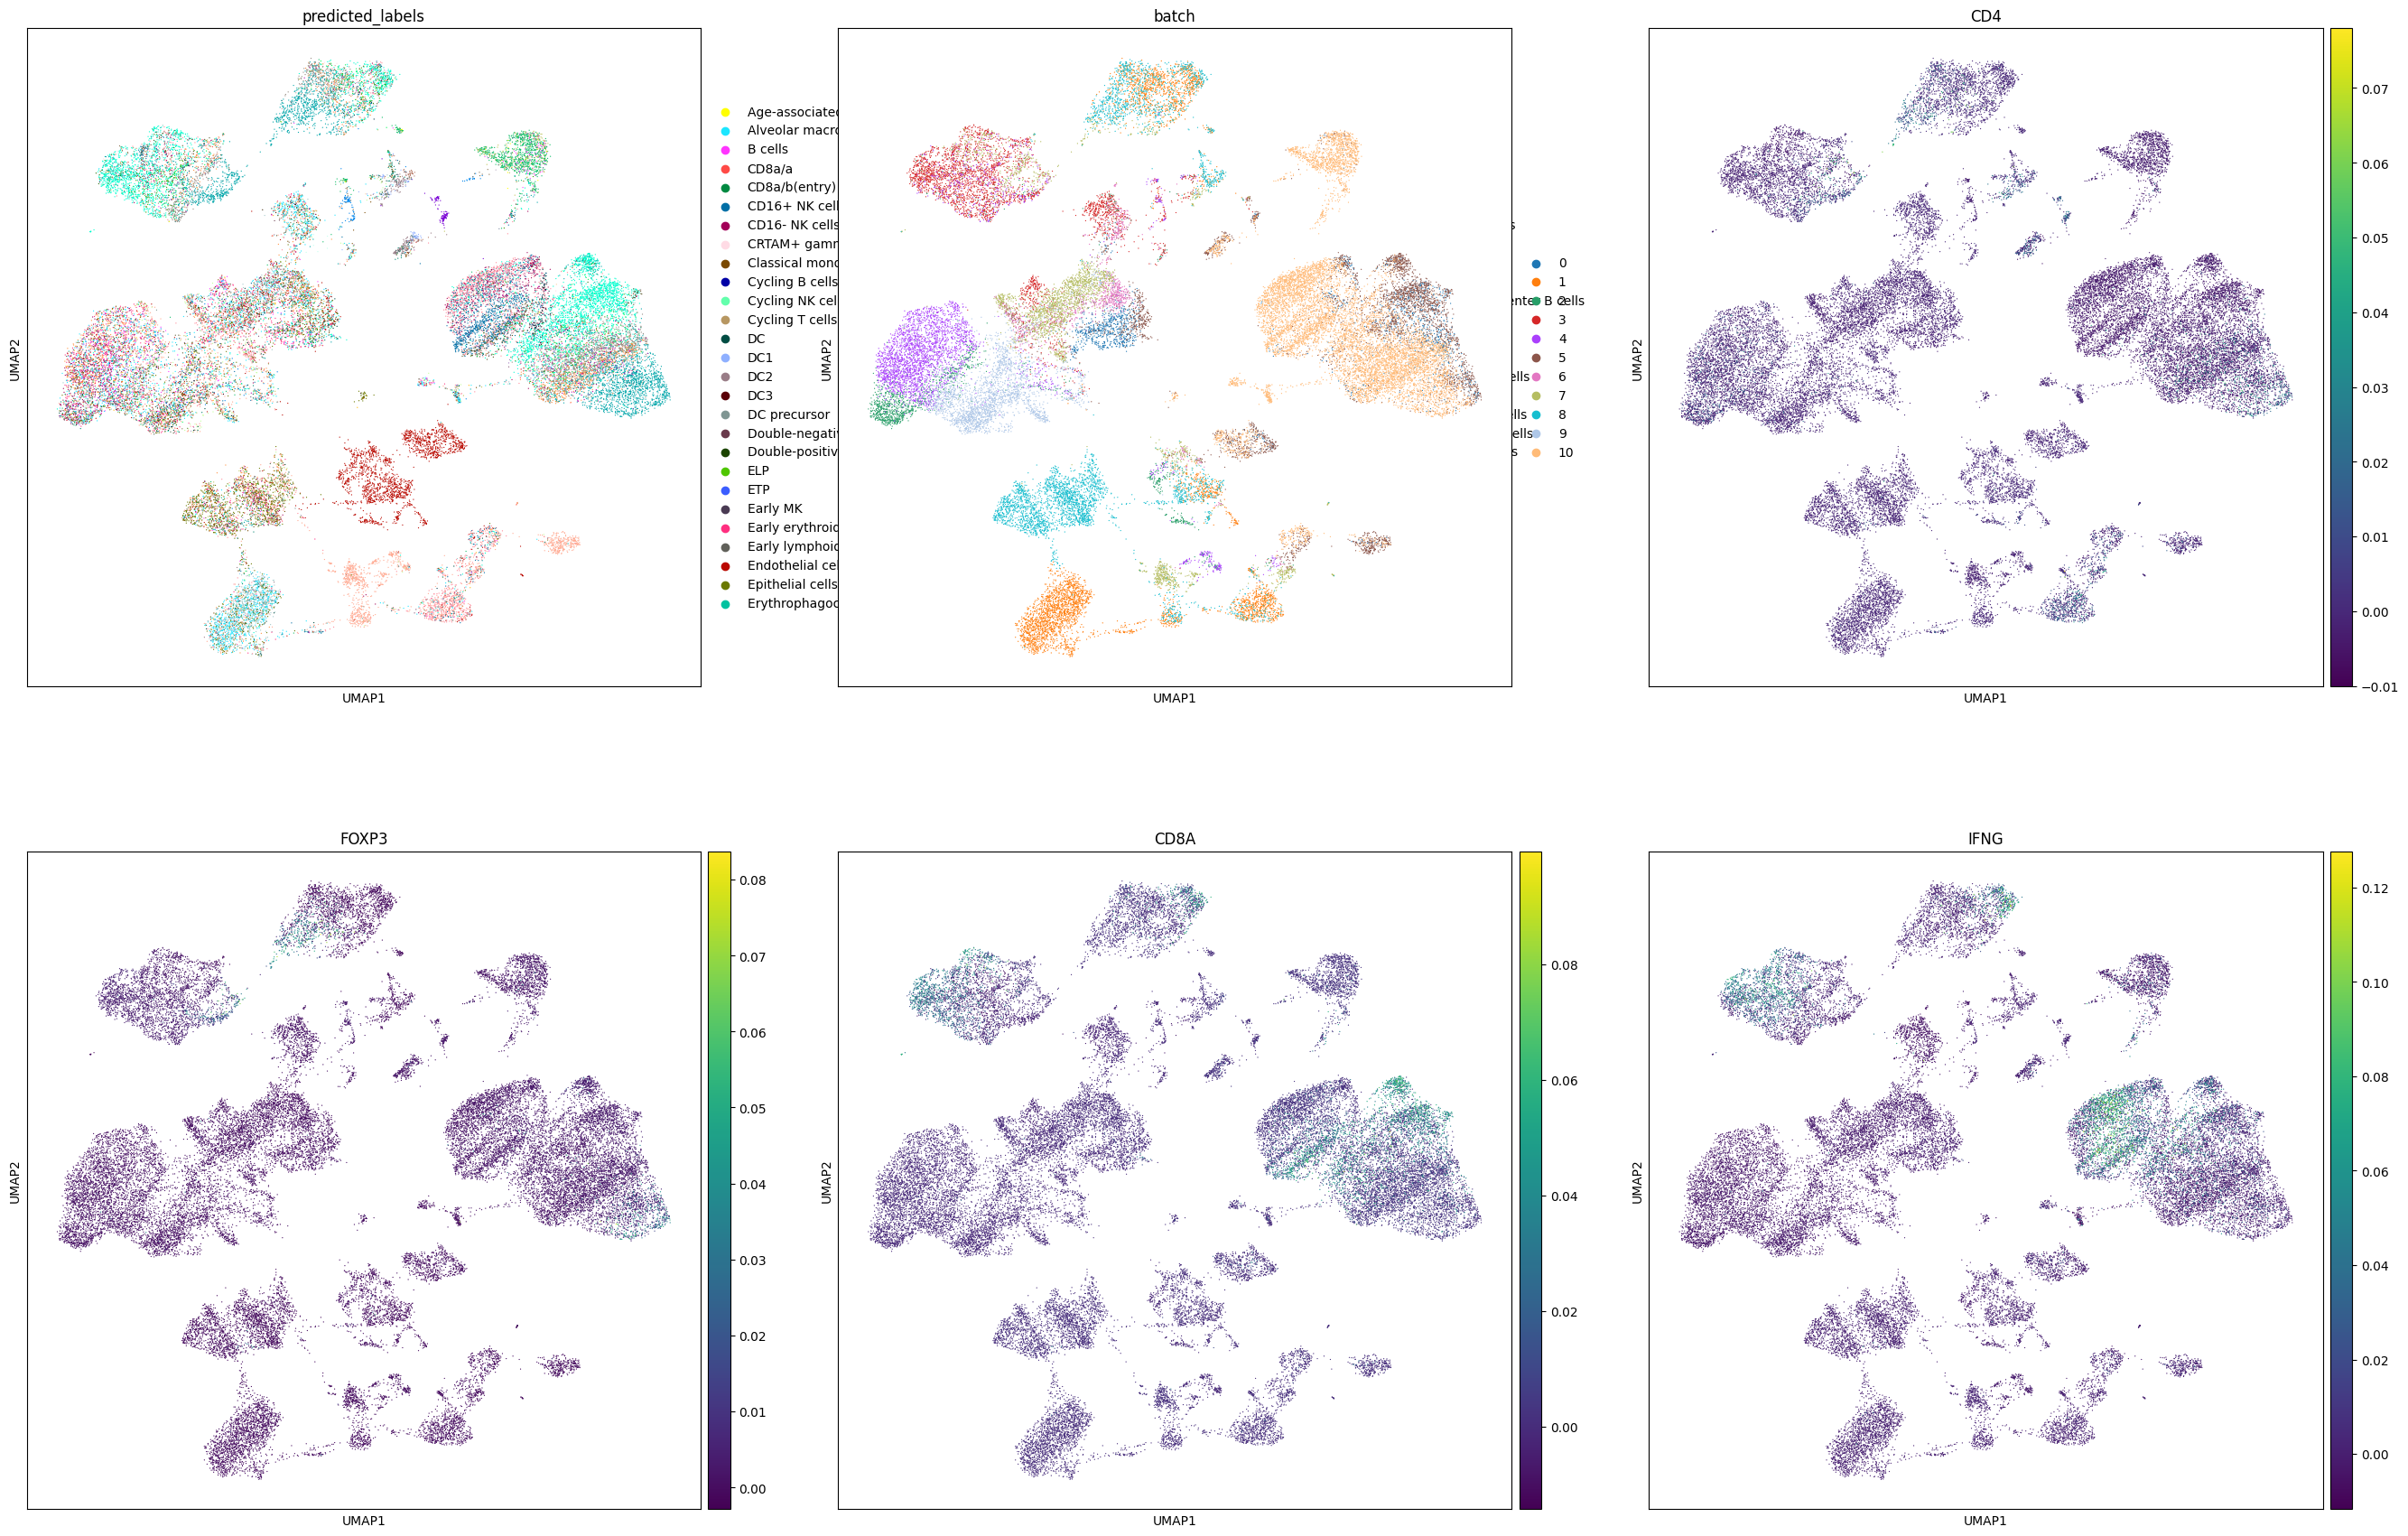

In [277]:
sc.pl.umap(
    adata, 
    color = ['predicted_labels', 'batch', 'CD4', 'FOXP3', 'CD8A', 'IFNG'], 
    ncols=3)

In [279]:
sc.tl.umap(adata, spread=0)

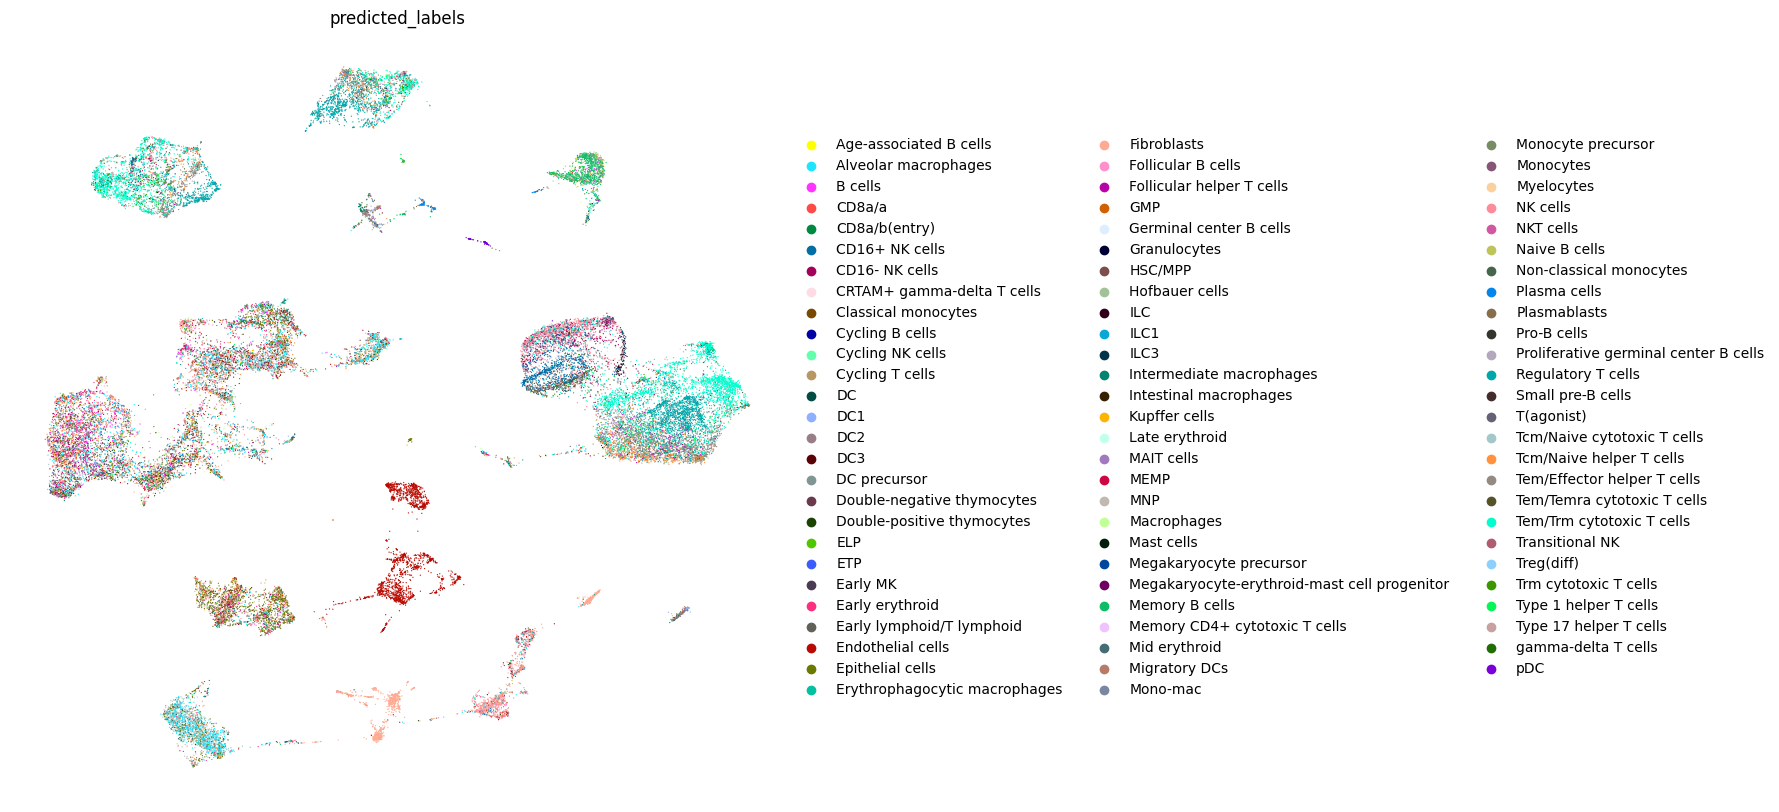

In [280]:
sc.pl.umap(
    adata, 
    color = ['predicted_labels'], frameon=False)

In [283]:
adata.layers

LayersView with keys: raw_count

In [282]:
adata = adata[~adata.obs.index.duplicated(keep='first')]
adata

View of AnnData object with n_obs × n_vars = 37978 × 8000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'predicted_labels_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [284]:
adata.X.toarray().sum(0)

array([5.12606615e+02, 1.27951573e-01, 7.34631892e+01, ...,
       8.66889195e+01, 5.47814633e+02, 1.23095718e+02])

In [285]:
adata

View of AnnData object with n_obs × n_vars = 37978 × 8000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'predicted_labels_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap', 'X_scanorama'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [46]:
import matplotlib.pyplot as plt
import pandas as pd

In [124]:
df = pd.DataFrame(adata.obs['predicted_labels'].value_counts() > 100).reset_index()

In [126]:
adata[adata.obs.predicted_labels.isin(df[df['count'] == True].predicted_labels.tolist()), :].obs['predicted_labels'].value_counts()

predicted_labels
T cells              4806
ILC                  2831
B cells              1194
Endothelial cells     238
Macrophages           159
DC                    102
Fibroblasts           101
Name: count, dtype: int64

In [127]:
adata = adata[adata.obs.predicted_labels.isin(df[df['count'] == True].predicted_labels.tolist()), :]

In [128]:
adata.obs['predicted_labels'].value_counts()

predicted_labels
T cells              4806
ILC                  2831
B cells              1194
Endothelial cells     238
Macrophages           159
DC                    102
Fibroblasts           101
Name: count, dtype: int64

In [134]:
sc.tl.umap(adata, spread=0.3)

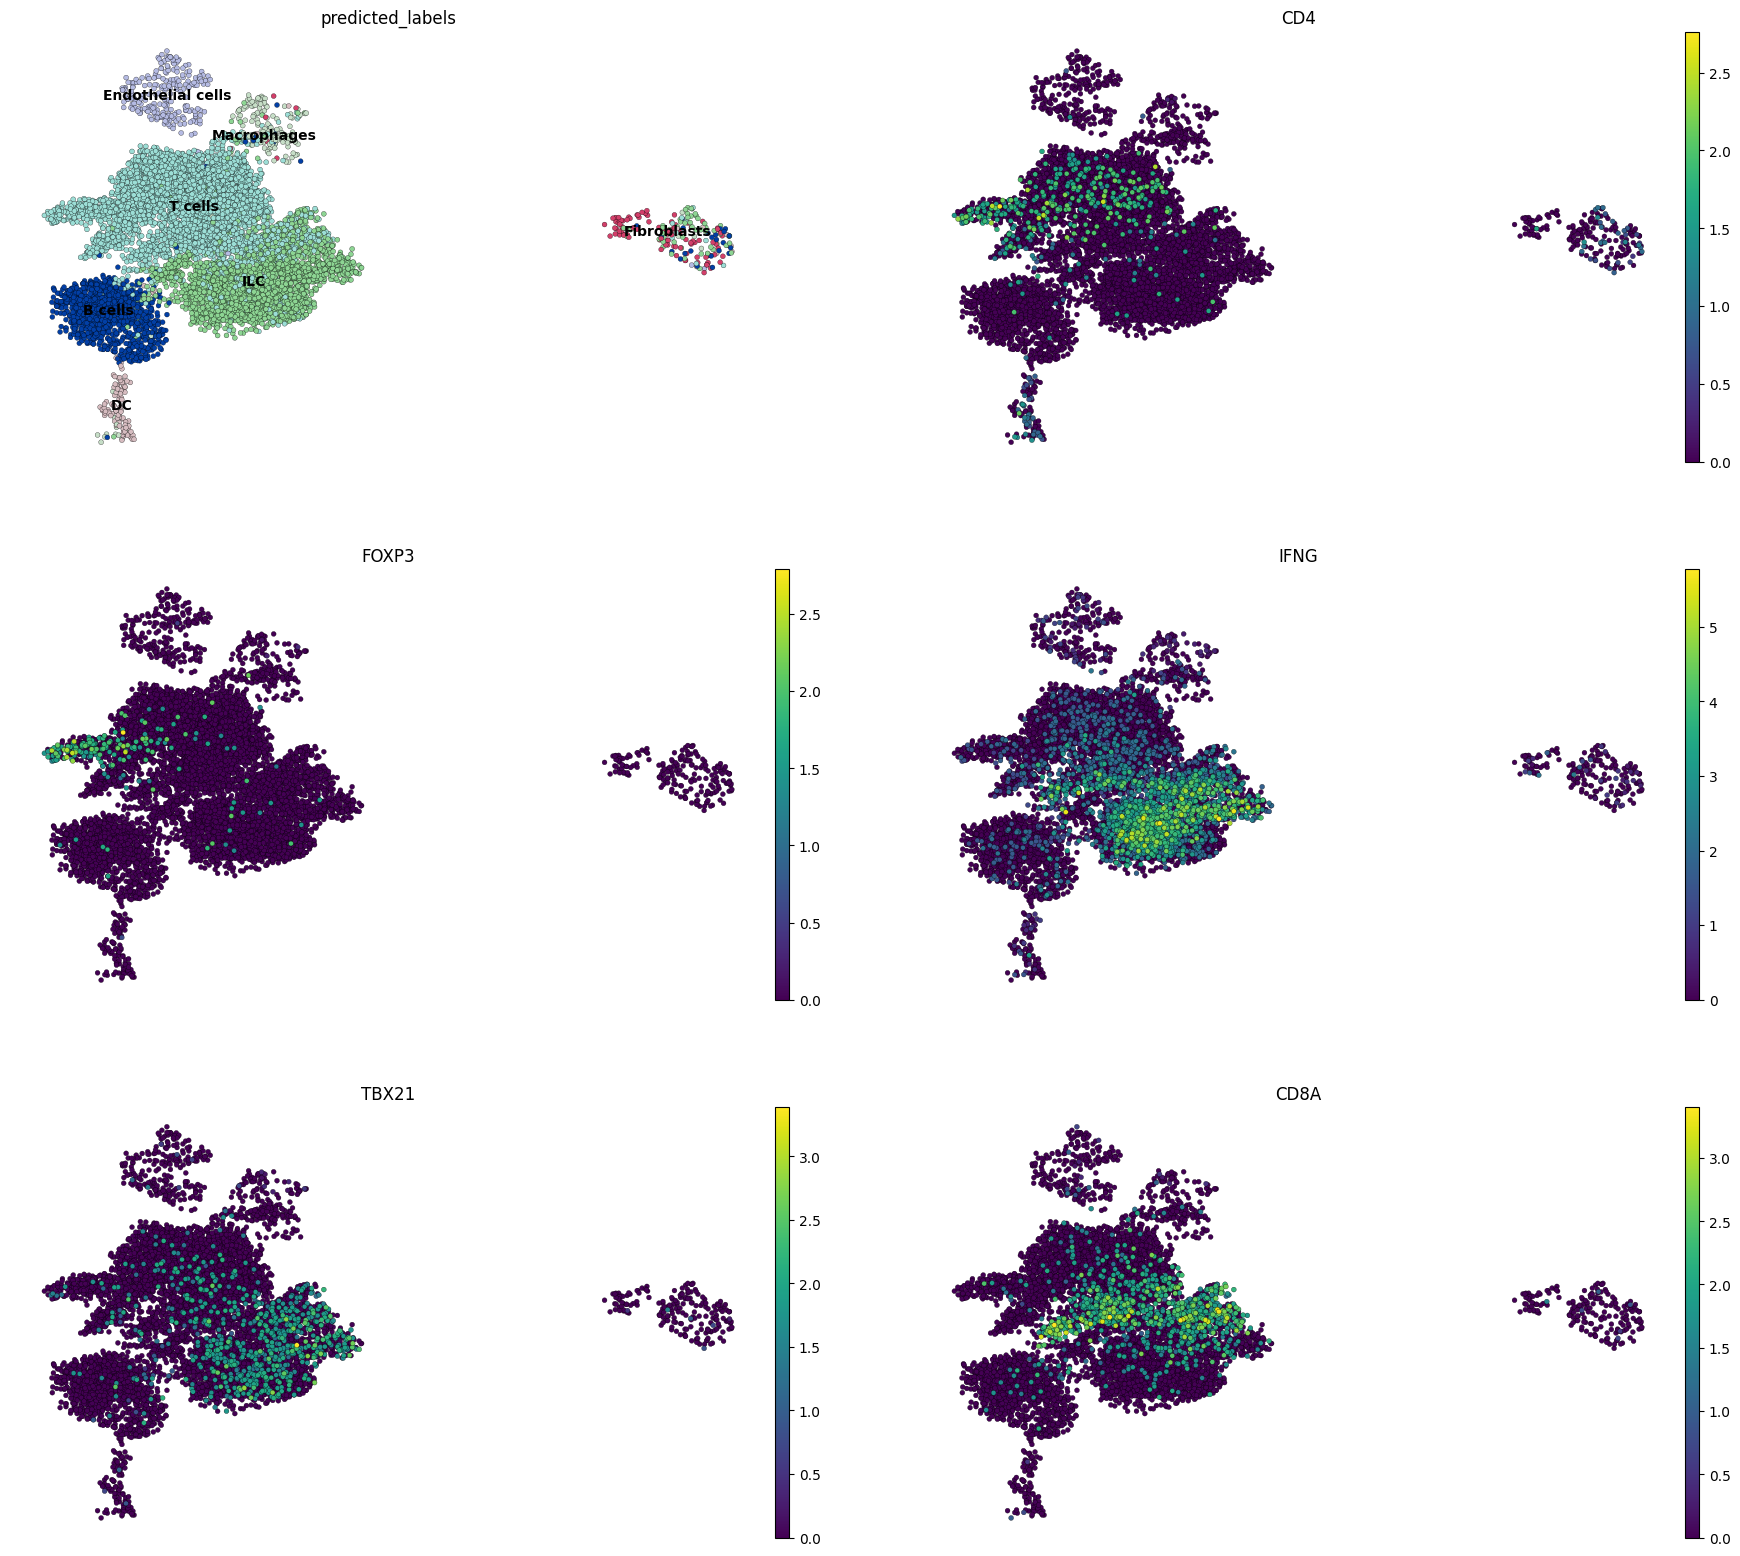

In [135]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sc.pl.umap(
    adata,
    ncols=2, s=50, linewidth=0.2, edgecolor='k',
    color = ['predicted_labels', 'CD4', 'FOXP3', 'IFNG', 'TBX21', 'CD8A'], 
    legend_loc = 'on data', frameon = False)

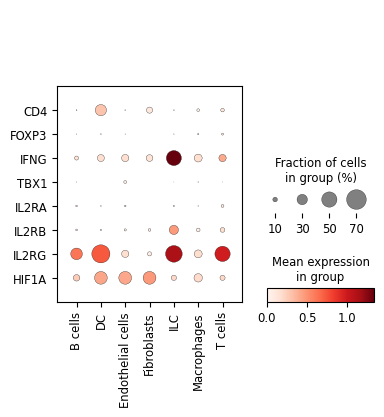

In [136]:
sc.pl.dotplot(
    adata, 
    var_names = ['CD4', 'FOXP3', 'IFNG', 'TBX1', 'IL2RA', 'IL2RB', 'IL2RG', 'HIF1A'], 
    groupby='predicted_labels',
    use_raw=False,
    swap_axes=True,)


In [139]:
import sys
sys.path.append('../../src')

In [140]:
import celloracle as co

In [141]:
base_GRN = co.data.load_human_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


In [142]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_diffmap')

In [143]:
sc.tl.paga(adata, groups='predicted_labels')

In [144]:
adata.to_df().mean(0)

AL627309.1    0.001021
AL669831.5    0.010132
LINC00115     0.010966
KLHL17        0.006706
PLEKHN1       0.011646
                ...   
C21orf58      0.009928
PCNT          0.021512
DIP2A         0.093848
S100B         0.268462
AL592183.1    0.036327
Length: 8000, dtype: float32

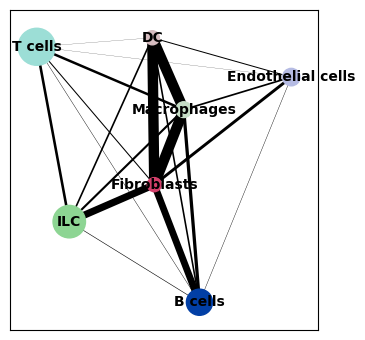

In [146]:
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.paga(adata)

In [147]:
sc.tl.draw_graph(adata, init_pos='paga', random_state=123)

In [148]:
oracle = co.Oracle()

In [149]:
adata.obs['predicted_labels'].value_counts()

predicted_labels
T cells              4806
ILC                  2831
B cells              1194
Endothelial cells     238
Macrophages           159
DC                    102
Fibroblasts           101
Name: count, dtype: int64

In [150]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="predicted_labels",
                                   embedding_name="X_draw_graph_fr")

8000 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


In [151]:
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [152]:
import matplotlib.pyplot as plt

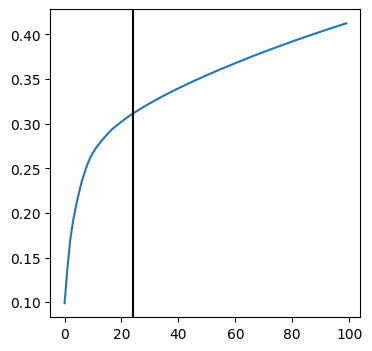

24


In [153]:
%matplotlib inline

# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

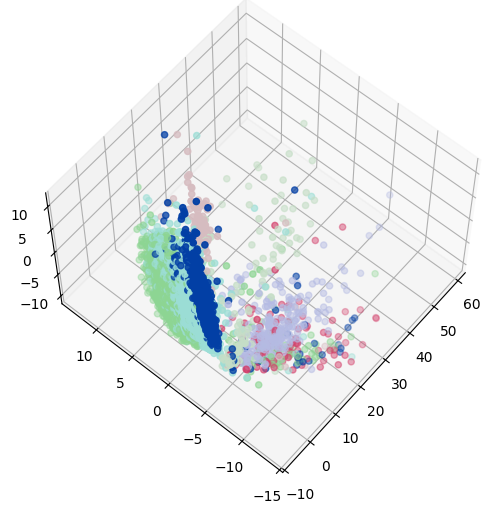

In [154]:
oracle.plot_pca()

In [155]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :9431


In [156]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :235


In [157]:
%%time 

oracle.knn_imputation(
    n_pca_dims=n_comps, 
    k=k, 
    balanced=True, 
    b_sight=k*8,
    b_maxl=k*4, 
    n_jobs=4
)

CPU times: user 4min 36s, sys: 3.26 s, total: 4min 39s
Wall time: 1min 18s


In [158]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="predicted_labels", 
    alpha=10,
    verbose_level=10
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for B cells...


  0%|          | 0/6662 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [06:30<39:01, 390.21s/it]

Inferring GRN for DC...


  0%|          | 0/6662 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [12:20<30:34, 366.82s/it]

Inferring GRN for Endothelial cells...


  0%|          | 0/6662 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [18:12<23:59, 359.98s/it]

Inferring GRN for Fibroblasts...


  0%|          | 0/6662 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [23:59<17:44, 354.88s/it]

Inferring GRN for ILC...


  0%|          | 0/6662 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [45:19<22:56, 688.38s/it]

Inferring GRN for Macrophages...


  0%|          | 0/6662 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [51:03<09:31, 571.39s/it]

Inferring GRN for T cells...


  0%|          | 0/6662 [00:00<?, ?it/s]

100%|██████████| 7/7 [2:15:57<00:00, 1165.30s/it]

CPU times: user 36min 18s, sys: 52.1 s, total: 37min 10s
Wall time: 2h 15min 57s


In [32]:
import pickle

with open('/tmp/melanoma_links_1.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

NameError: name 'links' is not defined

In [328]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10,
    use_cluster_specific_TFdict=True
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [336]:
# sc.pl.draw_graph(
#     oracle.adata, 
#     ncols=1, size=30, linewidth=0.2, edgecolor='k',
#     color=['FOXP3', 'IFNG', oracle.cluster_column_name],
#     layer="imputed_count", use_raw=False, cmap="viridis"
# )

In [ ]:
plt.rcParams['figure.figsize'] = (12, 4)
sc.get.obs_df(oracle.adata, keys=['FOXP3', 'TBX21'], layer="imputed_count").hist()
plt.show()

In [360]:
oracle.simulate_shift(
    perturb_condition={
        'FOXP3': 1.0, 
        'TBX21': 0.15
    },
    n_propagation=3
)

: 